# Results summary


In [1]:
# utils
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sincfold.metrics import f1_strict
from sincfold.utils import dot2bp
import json

## Ablation study 

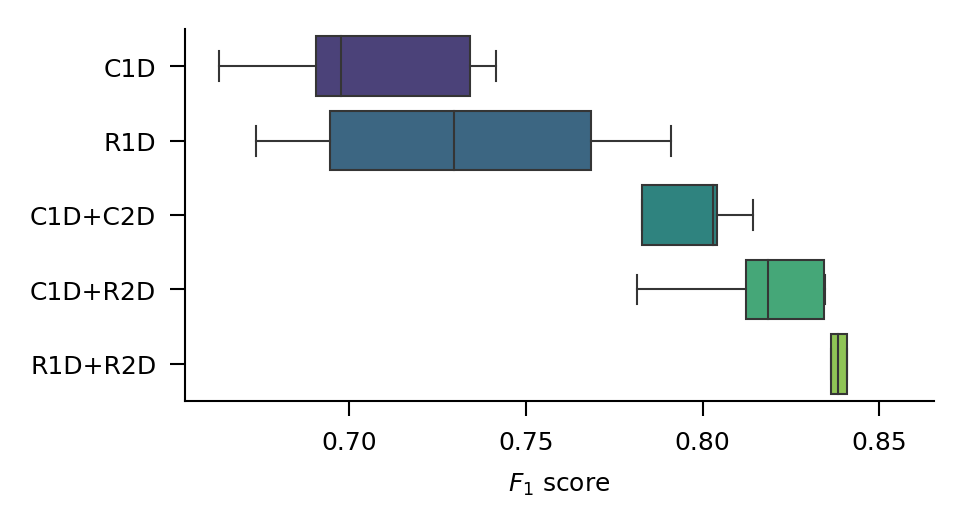

In [2]:
dotbracket_format = ["IPknot", "ProbKnot", "RNAstructure", "LinearFold", "REDfold", 
                          "LinearFold-C", "LinearFold-V", "LinearPartition-C", "LinearPartition-V", "MXfold2"]
methods = ["C1D", "R1D", "C1D+C2D", "C1D+R2D", "R1D+R2D"]
summary = pd.read_csv(f"ablation.csv", index_col="id")

dataset = pd.read_csv(f"../data/ablation.csv", index_col="id")
splits = pd.read_csv(f"../data/ablation_splits.csv")

# add references and compute F1 per sequence
summary["ref"] = dataset.loc[summary.index]["base_pairs"].apply(lambda x: json.loads(x))        


def get_f1(x):
    if x.method in dotbracket_format:
        _, _, f1 = f1_strict(x["ref"], dot2bp(x["folding"]))
    else:
        _, _, f1 = f1_strict(x["ref"], json.loads(x["folding"]))
    
    return f1

summary["F1"] = summary.apply(get_f1, axis=1)

# add fold id
for fold_number in splits.fold_number.unique():
    test_ids = splits[(splits.partition=="test") & (splits.fold_number==fold_number)].id
    summary.loc[summary.index.isin(test_ids), "fold_number"] = fold_number

# average over folds
summary_avg = summary.groupby(["fold_number", "method"]).F1.mean().unstack().T

plt.figure(figsize=(3.22, 1.61), dpi=300)

ax = sns.boxplot(data=summary_avg.T,  orient="h", palette="viridis" , order=methods, linewidth=0.5, fliersize=0)
ax.set_xlabel("$F_1$ score", fontsize=6)
ax.set_ylabel("")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(width=0.5)

plt.savefig("ablation.pdf", 
               bbox_inches='tight', 
               transparent=False,
               dpi=300,
               pad_inches=0)

### Interconnection distances

In [4]:
bins = np.linspace(0, 400, 40+1)
histn = {}
for method in ["R1D", "R1D+R2D"]:
    method_summary = summary[summary.method==method]
    tps = [] # true positives

    for k in range(len(method_summary)):
        for p in method_summary.iloc[k].ref:
            tp = 1
            if p not in json.loads(method_summary.iloc[k].folding): # strict error
                tp = 0
            tps.append([p[1]-p[0], tp])
    tps = pd.DataFrame(tps, columns=["dist", "tp"])
 
    h = []
    for i in range(len(bins)-1):
        nn = tps[(tps.dist>bins[i]) & (tps.dist<=bins[i+1])].tp.count()
        tp = tps[(tps.dist>bins[i]) & (tps.dist<=bins[i+1]) &  (tps.tp==1)].tp.count()
        if nn>0: h.append(tp/nn)
        else: h.append(0)
    histn[method] = h

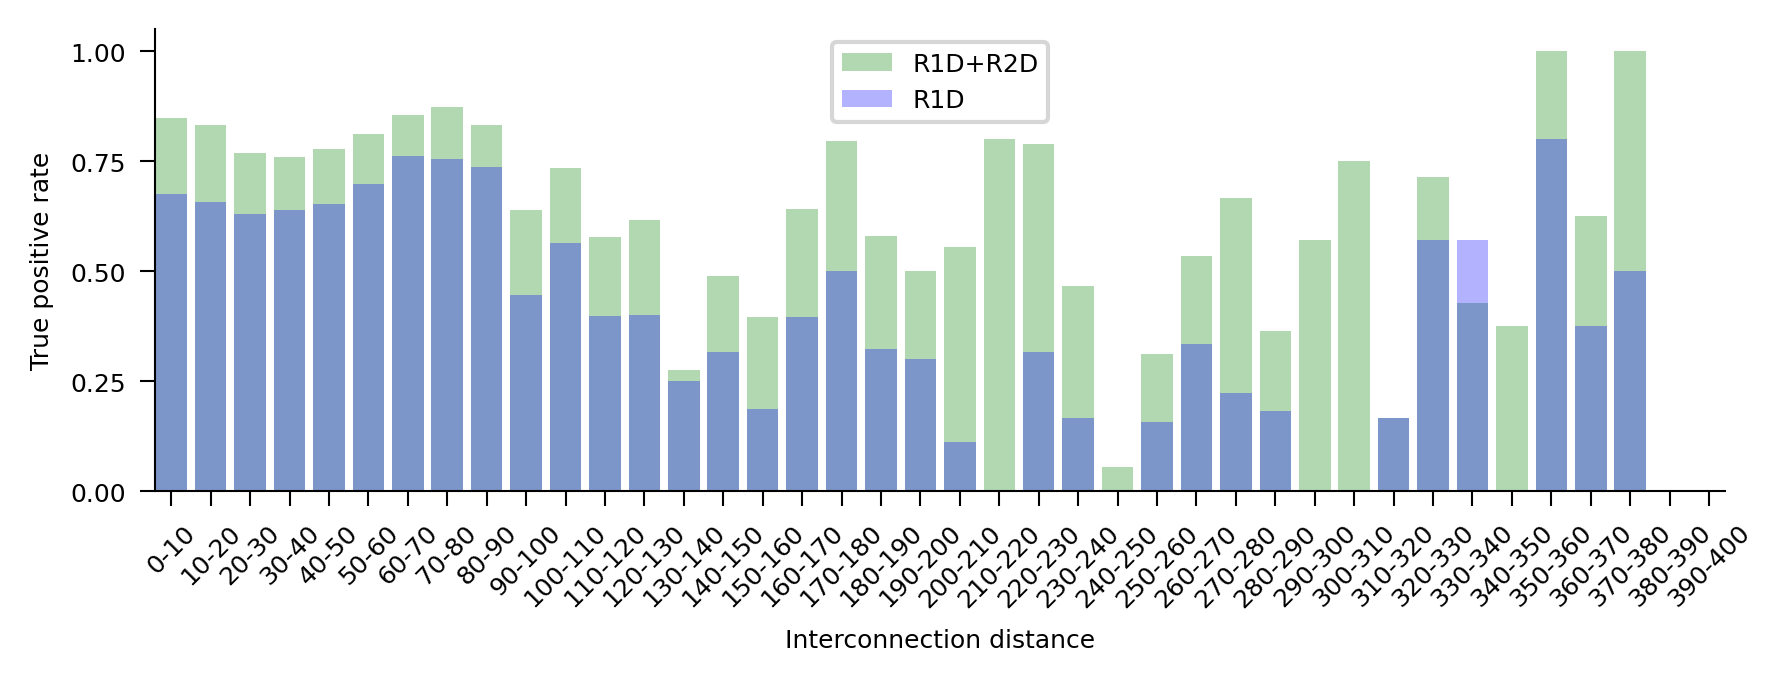

In [5]:
plt.figure(figsize=(6.75, 2), dpi=300)

strbins = []
for i in range(len(bins)-1):
    strbins.append(str(int(bins[i])) + "-" + str(int(bins[i+1])))

plt.bar(x=strbins, height=histn["R1D+R2D"], color="g", alpha=0.3, label="R1D+R2D")
plt.bar(x=strbins, height=histn["R1D"], color="b", alpha=0.3, label="R1D")
plt.xticks(rotation = 45, fontsize=6)
plt.yticks(fontsize=6)
plt.ylabel("True positive rate", fontsize=6)
plt.xlabel("Interconnection distance", fontsize=6)
plt.legend(fontsize=6)

plt.autoscale(enable=True, axis='x', tight=True)

ax = plt.gca()
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(width=0.5)

plt.savefig("distR.pdf", 
               bbox_inches='tight', 
               transparent=False,
               dpi=300,
               pad_inches=0)

## RNAstralign

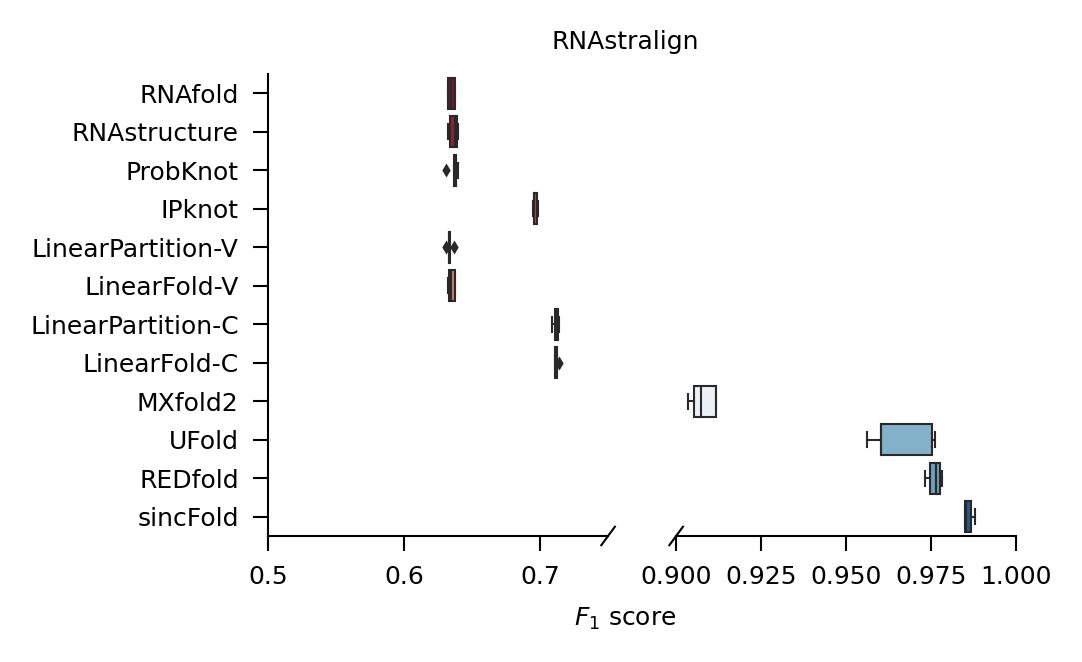

In [3]:
dotbracket_format = ["IPknot", "ProbKnot", "RNAstructure", "LinearFold", "REDfold", 
                          "LinearFold-C", "LinearFold-V", "LinearPartition-C", "LinearPartition-V", "MXfold2"]

methods = ['RNAfold', 'RNAstructure', 'ProbKnot', 'IPknot', 'LinearPartition-V', 'LinearFold-V', 
           'LinearPartition-C', 'LinearFold-C',   
           'MXfold2', 'UFold', 'REDfold', 'sincFold']

summary = pd.read_csv(f"RNAstralign.csv", index_col="id")

dataset = pd.read_csv(f"../data/RNAstralign.csv", index_col="id")
splits = pd.read_csv(f"../data/RNAstralign_splits.csv")

# add references and compute F1 per sequence
summary["ref"] = dataset.loc[summary.index]["base_pairs"].apply(lambda x: json.loads(x))        

summary["F1"] = summary.apply(get_f1, axis=1)

# add fold id
for fold_number in splits.fold_number.unique():
    test_ids = splits[(splits.partition=="test") & (splits.fold_number==fold_number)].id
    summary.loc[summary.index.isin(test_ids), "fold_number"] = fold_number

# add average over folds
summary = summary.groupby(["fold_number", "method"]).F1.mean().unstack().T

for method in methods:
    if method not in summary.index:
        summary = pd.concat((summary, pd.Series(index=[method])))

base = sns.color_palette("RdBu", 25)
palette = base[:6] + base[9:11] + base[13:14] + base[18:20] + base[-2:-1]

fig, ax = plt.subplots(1, 2, figsize=(3.22, 2), dpi=300)
sns.boxplot(data=summary.T,  orient="h", palette=palette, order=methods, hue_order=methods, ax=ax[0], linewidth=0.5, fliersize=1)
sns.boxplot(data=summary.T,  orient="h", palette=palette, order=methods, hue_order=methods, ax=ax[1], linewidth=0.5, fliersize=1)
ax[0].set_xlim(0.5, .75)
ax[1].set_xlim(.9, 1)
ax[1].set_ylabel("")
# remove ticks from ax[1]
ax[1].set_yticks([])
ax[0].set_title("RNAstralign", x=1.05, fontsize=6)

ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].tick_params(labelright=False)  

for axi in ax:
    axi.spines['left'].set_linewidth(0.5)
    axi.spines['bottom'].set_linewidth(0.5)
    axi.tick_params(labelsize=6)
    axi.tick_params(width=0.5)

d = .020 
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((1 - d, 1 + d), (-d, +d), lw=0.5, **kwargs)  

kwargs.update(transform=ax[1].transAxes)  
ax[1].plot((0 - d, 0 + d), (-d, +d), lw=0.5, **kwargs)  

ax[0].set_xlabel("$F_1$ score", x=1.05, fontsize=6)
ax[0].set_ylabel("")

## ArchiveII

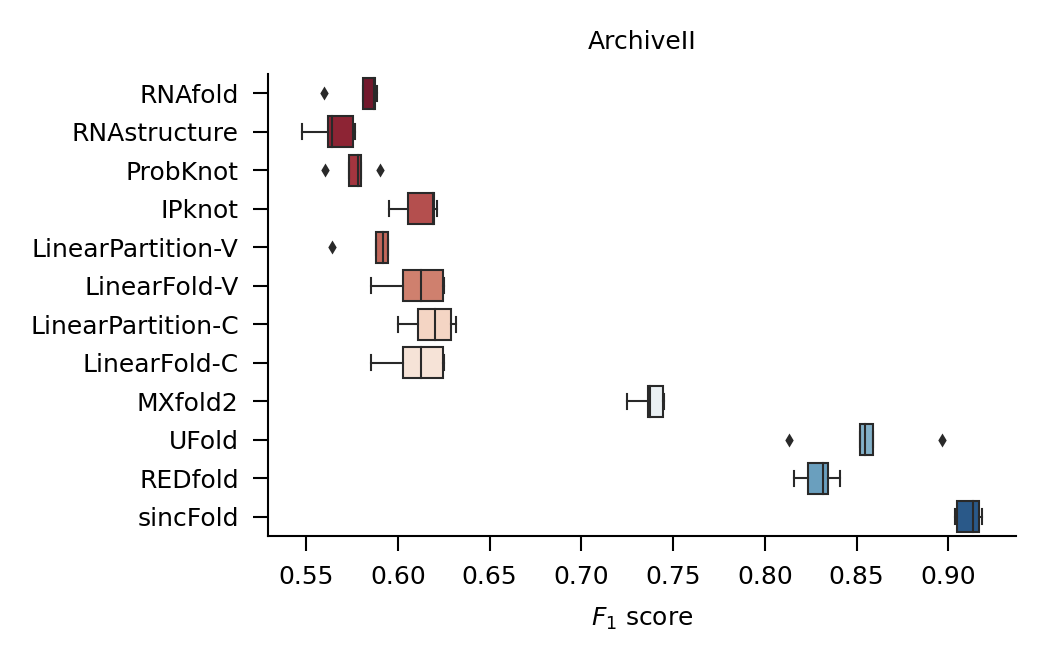

In [4]:
dotbracket_format = ["IPknot",  "RNAstructure", "REDfold", 
                          "LinearFold-C", "LinearFold-V", "LinearPartition-C", "LinearPartition-V", "MXfold2"]

methods = ['RNAfold', 'RNAstructure', 'ProbKnot', 'IPknot', 'LinearPartition-V', 'LinearFold-V', 
           'LinearPartition-C', 'LinearFold-C',   
           'MXfold2', 'UFold', 'REDfold', 'sincFold']

summary = pd.read_csv(f"ArchiveII.csv", index_col="id")

dataset = pd.read_csv(f"../data/ArchiveII.csv", index_col="id")
splits = pd.read_csv(f"../data/ArchiveII_splits.csv")

# add references and compute F1 per sequence
summary["ref"] = dataset.loc[summary.index]["base_pairs"].apply(lambda x: json.loads(x))        

summary["F1"] = summary.apply(get_f1, axis=1)

# add fold id
for fold_number in splits.fold_number.unique():
    test_ids = splits[(splits.partition=="test") & (splits.fold_number==fold_number)].id
    summary.loc[summary.index.isin(test_ids), "fold_number"] = fold_number

# add average over folds
summary_avg = summary.groupby(["fold_number", "method"]).F1.mean().unstack().T

fig, ax = plt.subplots(1, 1, figsize=(3.22, 2), dpi=300)
ax = sns.boxplot(data=summary_avg.T,  orient="h", palette=palette, order=methods, hue_order=methods, linewidth=0.5, fliersize=1)
ax.set_xlabel("$F_1$ score", fontsize=6)
ax.set_ylabel("")
ax.set_title("ArchiveII", fontsize=6)

#ax.set(yticklabels=[])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(labelright=False)  

ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.tick_params(labelsize=6)
ax.tick_params(width=0.5)

### Performance according to test-train structural distance on random partitions

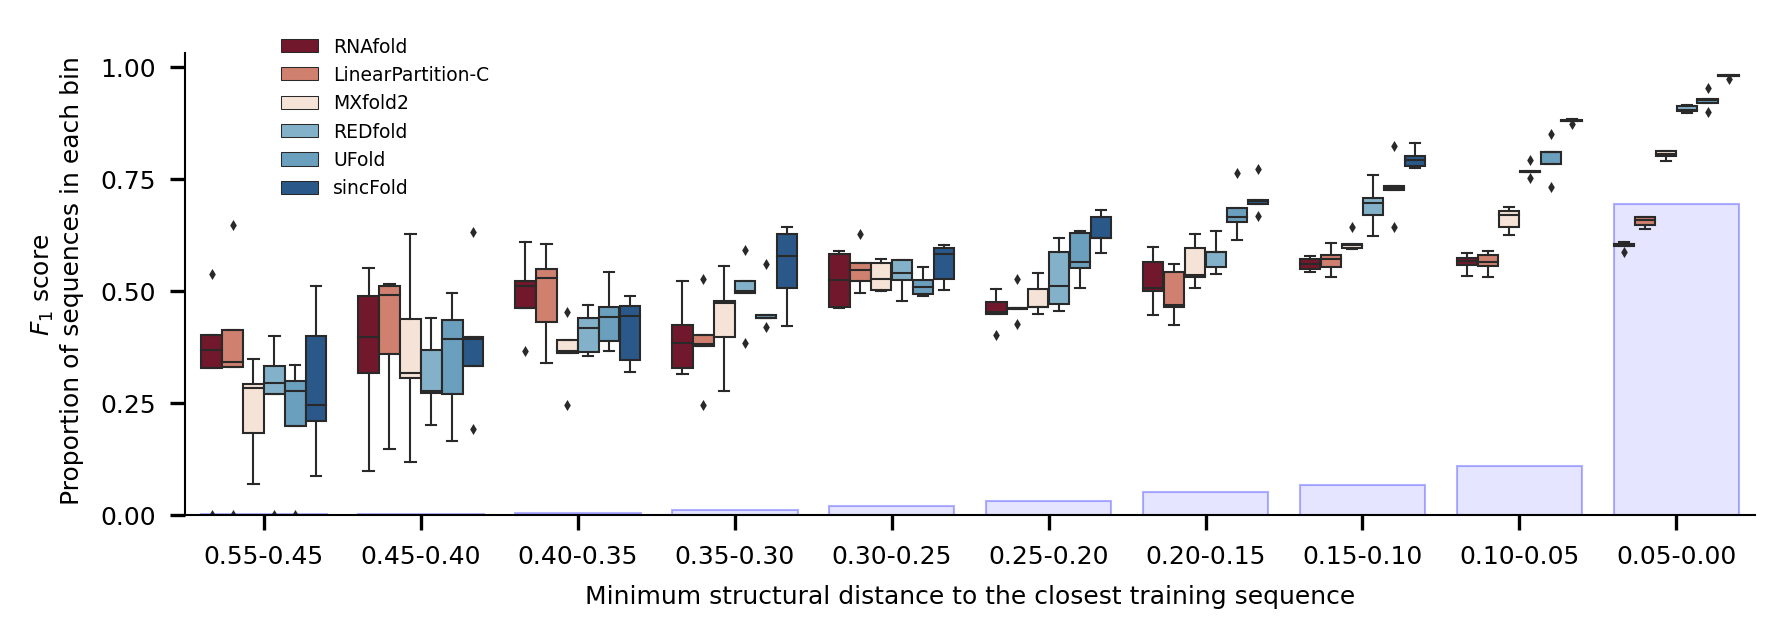

In [6]:
dist = splits[splits.partition=="test"].set_index("id")

pal = palette[:1] + palette[5:6] + palette[7:8] + palette[9:10] + palette[10:11] + palette[-1:]
methods = ['RNAfold', 'LinearPartition-C', 'MXfold2', 'REDfold', 'UFold', 'sincFold']

summary["min_train_dist"] = dist.loc[summary.index, "min_train_dist"]
summary["dist_bin"] = pd.cut(summary["min_train_dist"], include_lowest=True,  bins=[0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.55])
summary['dist_bin'] = summary.dist_bin.apply(lambda x: f'{x.right:.2f}-{x.left:.2f}' if x.right != 0.05 else f'{x.right:.2f}-{0:.2f}')

dist_count = summary.groupby("dist_bin").ref.count()
dist_count /= dist_count.sum()

# get average per fold per method and dist
summary_avg = summary.groupby(["fold_number", "method", "dist_bin"]).F1.mean().reset_index()

plt.figure(figsize=(6.75, 2), dpi=300)
bins = ['0.55-0.45', '0.45-0.40', '0.40-0.35', '0.35-0.30', '0.30-0.25', '0.25-0.20', '0.20-0.15', '0.15-0.10', '0.10-0.05', '0.05-0.00']
bp = sns.barplot(x=dist_count.index.to_numpy(), y=dist_count.values, 
                 facecolor=(0.0,0.0,1.0,0.1), linewidth=.5, 
                 edgecolor=(0.0,0.0,1.0,0.3), zorder=-1, order=bins)
vp = sns.boxplot(data=summary_avg, x="dist_bin", y="F1", hue="method", linewidth=.5, fliersize=0.5,
                 zorder=1, hue_order=methods, order=bins, palette=pal)
vp.set_ylabel("$F_1$ score \n Proportion of sequences in each bin", fontsize=6);
vp.legend(bbox_to_anchor=(0.05,.65), ncol=1, fontsize=4.5, frameon=False)
plt.xlabel("Minimum structural distance to the closest training sequence", fontsize=6);
vp.spines[['right', 'top']].set_visible(False);
vp.spines['left'].set_linewidth(0.5)
vp.spines['bottom'].set_linewidth(0.5)

plt.xticks(fontsize=6)
plt.yticks(fontsize=6);

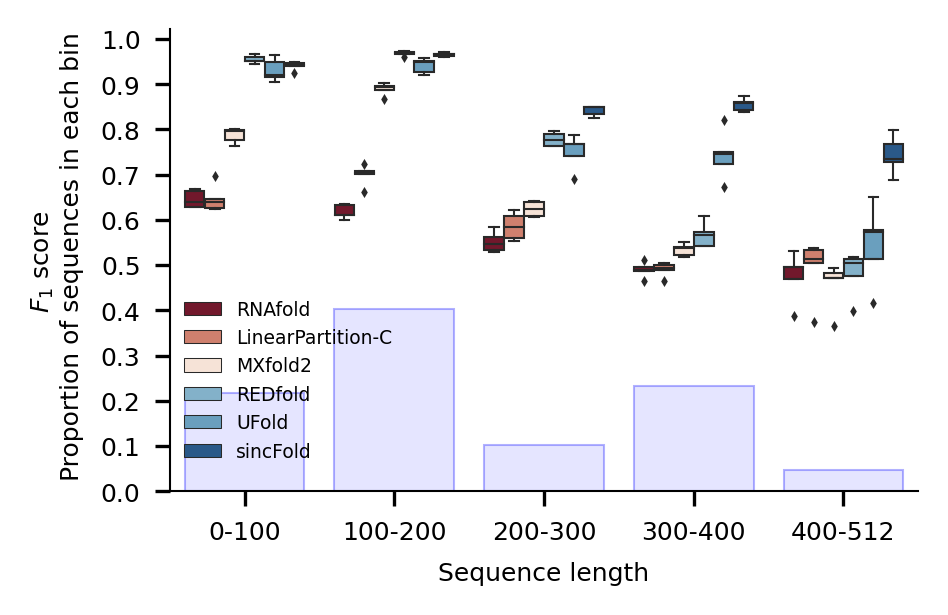

In [7]:
summary["Length"] = dataset.loc[summary.index, "len"]
summary["len_bin"] = pd.cut(summary["Length"], include_lowest=True,  bins=[0, 100, 200, 300, 400, 512])
summary['len_bin'] = summary.len_bin.apply(lambda x: f'{int(x.left)}-{int(x.right)}')

bin_count = summary.groupby("len_bin").ref.count()
bin_count /= bin_count.sum()

summary_avg = summary.groupby(["fold_number", "method", "len_bin"]).F1.mean().reset_index()

plt.figure(figsize=(3.22, 2), dpi=300)
bp = sns.barplot(x=bin_count.index, y=bin_count, 
                 facecolor=(0.0,0.0,1.0,0.1), linewidth=.5, 
                 edgecolor=(0.0,0.0,1.0,0.3), zorder=-1)
vp = sns.boxplot(data=summary_avg, x="len_bin", y="F1", hue="method", linewidth=.5, fliersize=.5, 
                 palette=pal, zorder=1, hue_order=methods, order=bin_count.index)
vp.set_ylabel("$F_1$ score \n Proportion of sequences in each bin", fontsize=6);
#vp.legend(bbox_to_anchor=(.95,.85), frameon=False, fontsize=4.5, ncol=1);
vp.legend(bbox_to_anchor=(.32,.24), frameon=False, fontsize=4.5, ncol=1);
plt.xlabel("Sequence length", fontsize=6);
vp.spines[['right', 'top']].set_visible(False);
vp.spines['left'].set_linewidth(0.5)
vp.spines['bottom'].set_linewidth(0.5)

# increase y ticks 
plt.yticks(np.arange(0, 1.1, .1), fontsize=6)

plt.xticks(fontsize=6)
plt.yticks(fontsize=6);

## Homology-aware validation

### TR0-TS0

In [13]:
import pandas as pd 
import json 
from sincfold.metrics import WL, f1_strict, mcc
from sincfold.utils import  dot2bp, bp2matrix

def get_metrics(x):
    try:
        if x.method in dotbracket_format:
            pred = dot2bp(x["folding"])
        else:
            pred = json.loads(x["folding"])
            
        _, _, f1 = f1_strict(x["ref"], pred)
        pred_mat = bp2matrix(x["L"], pred).numpy()
        ref_mat = bp2matrix(x["L"], x["ref"]).numpy()
        wl = WL(pred_mat, ref_mat, x["sequence"])
        inf = mcc(pred_mat, ref_mat)
    except:
        print(x.name, x.method)
    
    return f1, wl, inf

dotbracket_format = ["RNAstructure", "LinearFold", "REDfold", "RNAfold",
                          "LinearFold-C", "LinearFold-V", "LinearPartition-C", "LinearPartition-V", "MXfold2"]

summary = pd.read_csv(f"TR0-TS0.csv", index_col="id")

dataset = pd.read_csv(f"../data/TR0-TS0.csv", index_col="id")
splits = pd.read_csv(f"../data/TR0-TS0_splits.csv", index_col="id")
dataset = dataset.loc[splits[splits.partition=="TS0"].index]

# add references and compute F1 per sequence
summary["ref"] = dataset.loc[summary.index]["base_pairs"].apply(lambda x: json.loads(x))    
summary["L"] = dataset.loc[summary.index].sequence.str.len()    
summary["sequence"] = dataset.loc[summary.index].sequence    
# get metrics
summary["F1"], summary["WL"], summary["INF"] = zip(*summary.apply(get_metrics, axis=1))
summary.groupby(["method"])[["F1", "WL", "INF"]].mean().loc[methods]

,F1,WL,INF
method,,,
RNAfold,0.508013,0.680951,0.519687
LinearPartition-C,0.547173,0.737353,0.555723
MXfold2,0.502317,0.735587,0.508717
REDfold,0.620637,0.799825,0.625906
UFold,0.579879,0.742644,0.589669
sincFold,0.631124,0.827189,0.641295


### Inter-family performance

In [16]:
import pandas as pd 
import json 
from sincfold.metrics import WL, f1_strict, mcc
from sincfold.utils import  dot2bp, bp2matrix

def get_metrics(x):
    try:
        if x.method in dotbracket_format:
            pred = dot2bp(x["folding"])
        else:
            pred = json.loads(x["folding"])
            
        _, _, f1 = f1_strict(x["ref"], pred)
        pred_mat = bp2matrix(x["L"], pred).numpy()
        ref_mat = bp2matrix(x["L"], x["ref"]).numpy()
        wl = WL(pred_mat, ref_mat, x["sequence"])
        inf = mcc(pred_mat, ref_mat)
    except:
        print(x.name, x.method)
    
    return f1, wl, inf

dotbracket_format = ["RNAstructure", "LinearFold", "REDfold", 
                          "LinearFold-C", "LinearFold-V", "LinearPartition-C", "LinearPartition-V", "MXfold2"]

summary = pd.read_csv(f"ArchiveII_famfold.csv", index_col="id")

dataset = pd.read_csv(f"../data/ArchiveII.csv", index_col="id")

# add references and compute F1 per sequence
summary["ref"] = dataset.loc[summary.index]["base_pairs"].apply(lambda x: json.loads(x))    
summary["L"] = dataset.loc[summary.index].sequence.str.len()    
summary["sequence"] = dataset.loc[summary.index].sequence    
# get metrics
summary["F1"], summary["WL"], summary["INF"] = zip(*summary.apply(get_metrics, axis=1))
summary.groupby(["method"])[["F1", "WL", "INF"]].mean().loc[methods]

,F1,WL,INF
method,,,
RNAfold,0.580646,0.699369,0.580843
LinearPartition-C,0.618335,0.738068,0.619280
MXfold2,0.523421,0.669426,0.522947
REDfold,0.348574,0.609427,0.366430
UFold,0.351484,0.602634,0.370008
sincFold,0.413938,0.631354,0.432180


In [17]:
summary[summary.method.isin(["sincFold", "UFold", "REDfold"])].groupby(["family", "method"])[["F1"]].mean()

F1
family     method            
16s        REDfold   0.366000
           UFold     0.332391
           sincFold  0.391664
23s        REDfold   0.401774
           UFold     0.393633
           sincFold  0.402430
5s         REDfold   0.472025
           UFold     0.377045
           sincFold  0.438967
RNaseP     REDfold   0.357543
           UFold     0.421389
           sincFold  0.442618
grp1       REDfold   0.310811
           UFold     0.428962
           sincFold  0.349969
srp        REDfold   0.178760
           UFold     0.199409
           sincFold  0.249175
tRNA       REDfold   0.414961
           UFold     0.491916
           sincFold  0.685143
telomerase REDfold   0.112168
           UFold     0.177278
           sincFold  0.154173
tmRNA      REDfold   0.274052
           UFold     0.346815
           sincFold  0.350146